# MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

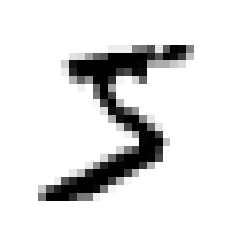

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = np.array(X.loc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y = y.astype(np.uint8)

In [6]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

* Stochastic Gradient Descent (SGD) classifier: this classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): #dumb classifier that classifies every single image in the “not-5” class
    
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### (Example of a customized cross-validation code that uses stratified sampling)

In [14]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3)

# for train_index, test_index in skfolds.split(X_train, y_train_5):
#     clone_clf = clone(sgd_clf)
#     X_train_folds = X_train.iloc[train_index]
#     y_train_folds = y_train_5.iloc[train_index]
#     X_test_fold = X_train.iloc[test_index]
#     y_test_fold = y_train_5.iloc[test_index]
#     clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
#     n_correct = sum(y_pred == y_test_fold)
#     print(n_correct / len(y_pred))

## Confusion Matrix 

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

In [17]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### * Precision = TP / (TP + FP)

### * Recall = TP / (TP + FN) 

Recall is also called sensitivity or true positive rate (TPR)

## Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1 score is the harmonic mean of precision and recall

F1 = ((precison^-1 + recall^-1)/2)^-1

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Trade-off

In [21]:
y_scores = sgd_clf.decision_function([some_digit])

In [22]:
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [24]:
y_some_digit_pred

array([ True])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

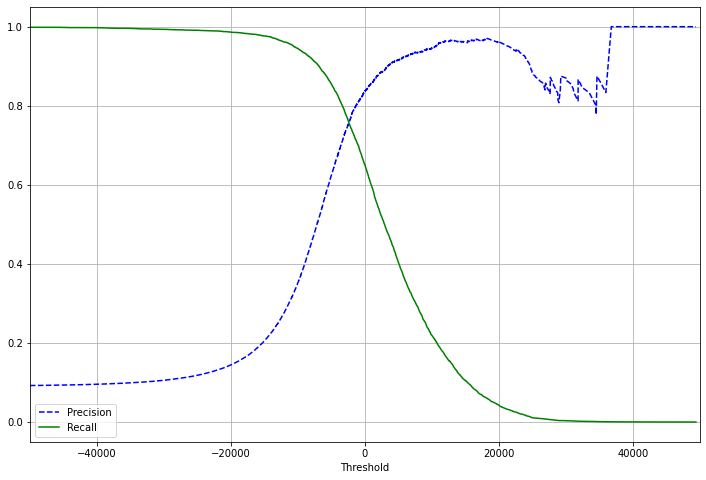

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlim([-50000, 50000])
    plt.xlabel('Threshold')
    plt.grid()
    plt.legend()
    plt.rcParams['font.size'] = 20
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

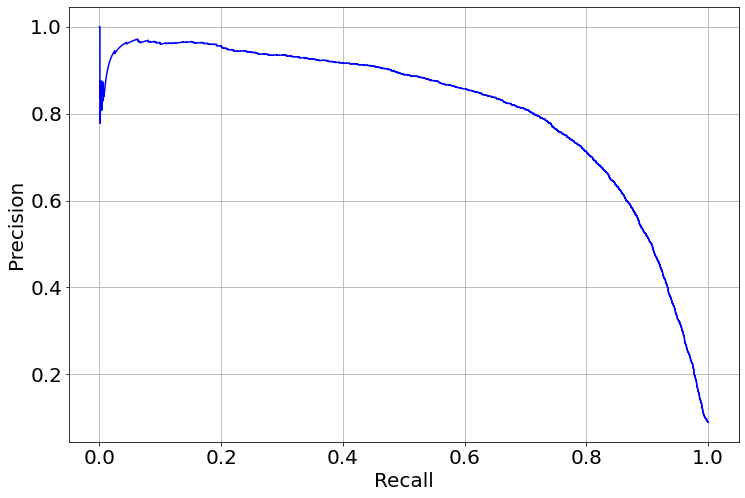

In [28]:
plt.figure(figsize=(12,8))
plt.plot(recalls[:-1], precisions[:-1], "b-")
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.rcParams['font.size'] = 18
plt.show()

In [29]:
type(thresholds)

numpy.ndarray

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [31]:
threshold_90_precision

3370.019499143958

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC curve (receiver operating characteristic)

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.ylabel("Recall (True Positive Rate (TPR))")
    plt.xlabel("False Positive Rate (FPR)")
    plt.grid()
    

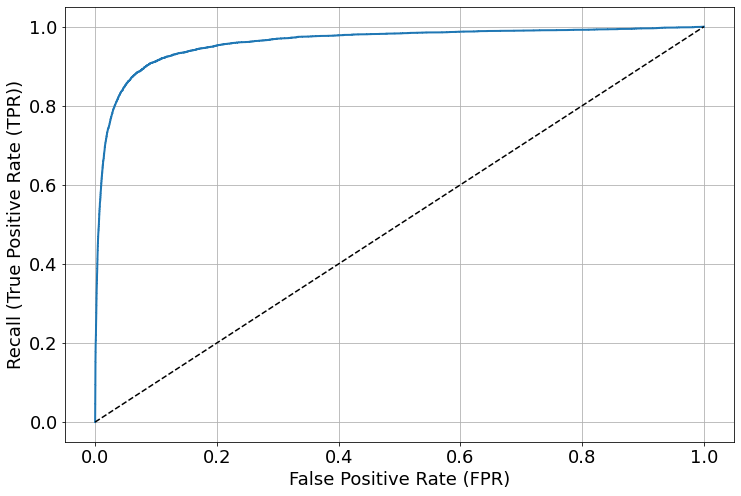

In [37]:
plt.figure(figsize=(12,8))
plt.rcParams['font.size'] = 18
plot_roc_curve(fpr,tpr)
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [40]:
y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

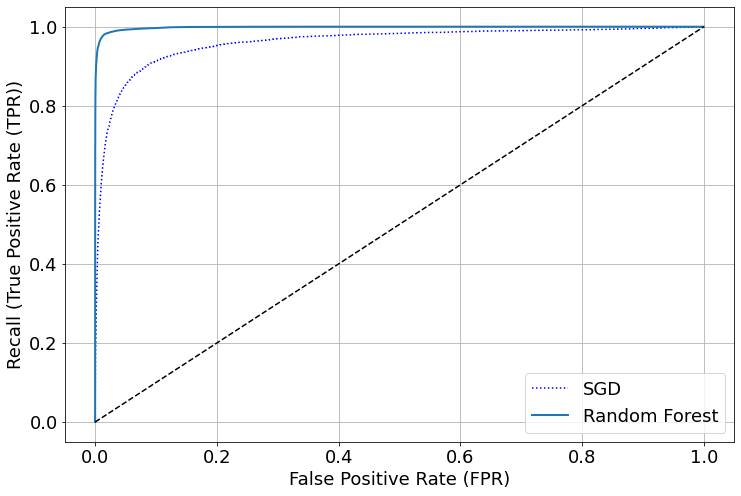

In [41]:
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.rcParams['font.size'] = 18
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

* Tip: Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

### FPR = FP / (FP + TN)

# Multiclass Classification

In [43]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

* Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [45]:
#Forcing SVC to use one-versus-the-rest

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [46]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

In [48]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [49]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [50]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

* You can improve the SGDClassifier accuracy by using StandardScaler 

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [54]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [55]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

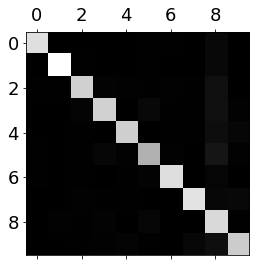

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [58]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

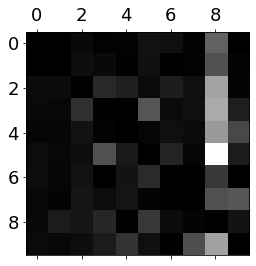

In [59]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [62]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [63]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

In [65]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

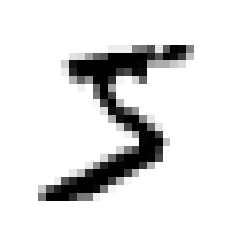

In [67]:
clean_digit = np.array(X_train.loc[0])
clean_digit_image = clean_digit.reshape(28, 28)

plt.imshow(clean_digit_image, cmap="binary")
plt.axis("off")
plt.show()

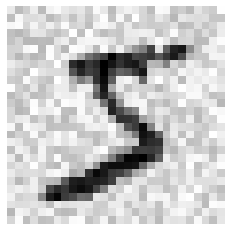

In [68]:
mod_digit = np.array(X_train_mod.loc[0])
mod_digit_image = mod_digit.reshape(28, 28)

plt.imshow(mod_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [69]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [76]:
pred_clean_digit = knn_clf.predict([X_test_mod.iloc[0]])

In [78]:
pred_im = pred_clean_digit.reshape(28,28)

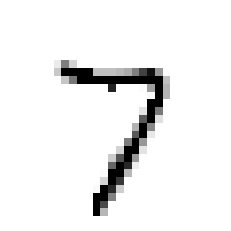

In [79]:
plt.imshow(pred_im, cmap="binary")
plt.axis("off")
plt.show()

In [84]:
clean_test_zero = np.array(X_test.iloc[0])

In [85]:
clean_test_zero_im = clean_test_zero.reshape(28,28)

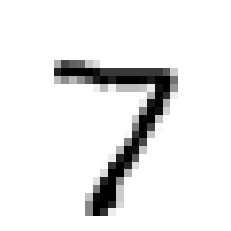

In [86]:
plt.imshow(clean_test_zero_im, cmap="binary")
plt.axis("off")
plt.show()